## Import packages:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick
from pandas.api.types import CategoricalDtype

### Initialize variables and functions:

In [4]:
idx = pd.IndexSlice
icelandic_days = [ 'Mánudagur', 'Þriðjudagur', 'Miðvikudagur', 'Fimmtudagur', 'Föstudagur', 'Laugardagur', 'Sunnudagur']
icelandic_days_categories = CategoricalDtype(categories=icelandic_days, ordered=True)

def GetDateRangeStr(dateColumn):
    startDate = dateColumn.min().strftime("%d.%b '%y")
    endDate = dateColumn.max().strftime("%d.%b '%y")
    return f"{startDate} - {endDate}"

def GetBusiestAirlines(df, number_of_airlines):
    df = df.assign(Week = df.Date.dt.strftime('%Y-%W'))
    busiest_weekly_flights = df.groupby(['Airline', 'Week']).pMins.count()
    return list(busiest_weekly_flights.groupby(level=0).mean().nlargest(number_of_airlines).index)

### Read dataset:

In [5]:
df_orig = pd.read_pickle(os.path.join('Flightdata', 'flight_departures.pickle')).drop(columns=["Type", "CreationDate"])
df_orig['WeekDay']=df_orig['WeekDay'].astype(icelandic_days_categories)
df_orig = df_orig[df_orig.Airline.isin(GetBusiestAirlines(df_orig, 8))]

df_a = df_orig[df_orig.Scenario == 'Actual'].drop(columns=['Scenario'])
df_p = df_orig[df_orig.Scenario == 'Plan'].drop(columns=['Scenario'])

current_week = df_a.Date.max().week

In [6]:
GetBusiestAirlines(df_a, 8)

['Icelandair',
 'Wizz Air',
 'Play',
 'Delta',
 'United Airlines',
 'Lufthansa',
 'SAS',
 'EasyJet']

### Punctuality for all airlines:

(0.0, 105.0)

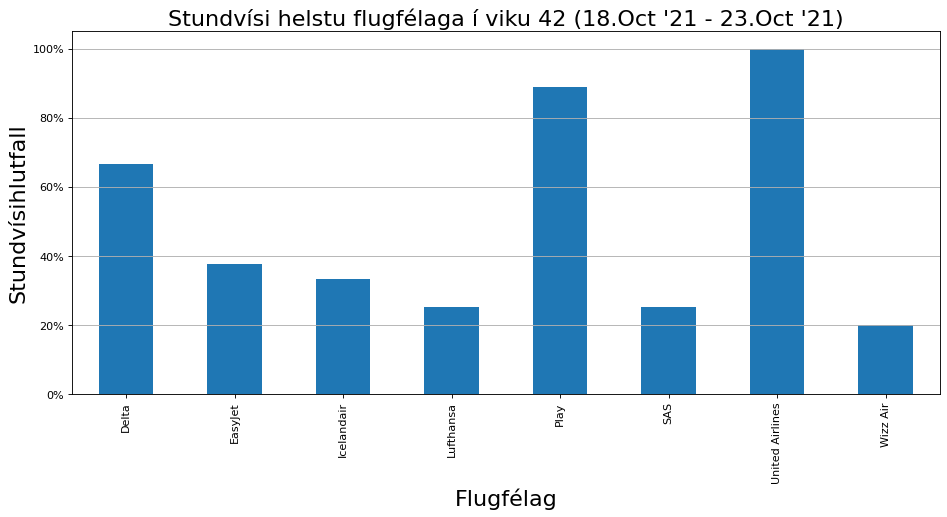

In [9]:
week = current_week
df_w = df_a[df_a.Date.dt.week == week]
date_range = GetDateRangeStr(df_w.Date)


result_airlines = df_w.groupby(['WeekDay', 'FlightNumber', 'Airline'])['pMins'].mean().dropna()
result_airlines_mean = df_w.groupby(['Airline'])['pMins'].mean().dropna()
result_airlines_median = df_w.groupby(['Airline'])['pMins'].median().dropna()
result_airlines_count = df_w.groupby(['Airline'])['pMins'].count().dropna()
result_airlines_pRatio = result_airlines.groupby(level=2).apply(lambda x: 100 * x[x<=0].count()/float(x.count()) )
result_airlines_cRatio = result_airlines_count.apply(lambda x: 100 * x / result_airlines_count.sum() )

figure(figsize=(14, 6), dpi=80)
ax = result_airlines_pRatio.plot.bar(x = 'Vikudagur', y='Stundvísihlutfall')
ax.set_title(f'Stundvísi helstu flugfélaga í viku {week} ({date_range})', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Flugfélag", fontsize=20)
ax.set_ylabel("Stundvísihlutfall", fontsize=20)
ax.set_ylim(0, 105)

### Punctuality for the Icelandic airlines:

In [10]:
df = df_a[df_a.Date.dt.week < current_week]
# df = df[df.pMins > 0]

df = df[df.Airline.isin(['Icelandair', 'Play'])]
df = df.assign(WoY = df.Date.dt.strftime("%Y-%W"))

date_range = GetDateRangeStr(df.Date)

df_result_week_mean = df.groupby(['WoY', 'Airline'])['pMins'].mean().dropna()
df_result_week_min = df.groupby(['WoY', 'Airline'])['pMins'].min().dropna()
df_result_week_max = df.groupby(['WoY', 'Airline'])['pMins'].max().dropna()

df_result_week_sum = df.groupby(['WoY', 'Airline'])['pMins'].sum().dropna()
df_result_week_count = df.groupby(['WoY', 'Airline'])['pMins'].count().dropna()

df_result = df.groupby(['WoY', 'WeekDay', 'FlightNumber', 'Airline'])['pMins'].mean().dropna()
df_result_week_cRatio = df_result_week_count.groupby(level=0).apply(lambda x: 100 * (x / x.sum()))
df_result_week_pRatio = df_result.groupby(['WoY', 'Airline']).apply(lambda x: 100 * (x[x<=0].count() / x.count()))

(0.0, 105.0)

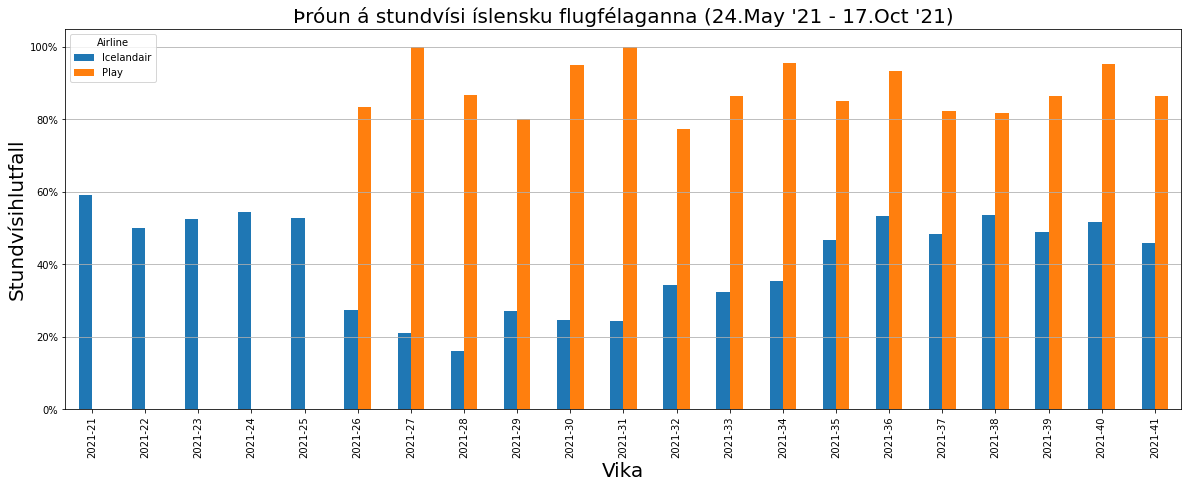

In [11]:
ax = df_result_week_pRatio.unstack(level=1).plot.bar(figsize=(20,7))
ax.set_title(f'Þróun á stundvísi íslensku flugfélaganna ({date_range})', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika", fontsize=20)
ax.set_ylabel("Stundvísihlutfall", fontsize=20)
ax.set_ylim(0, 105)

Text(0, 0.5, 'Fjöldi flugferða í viku')

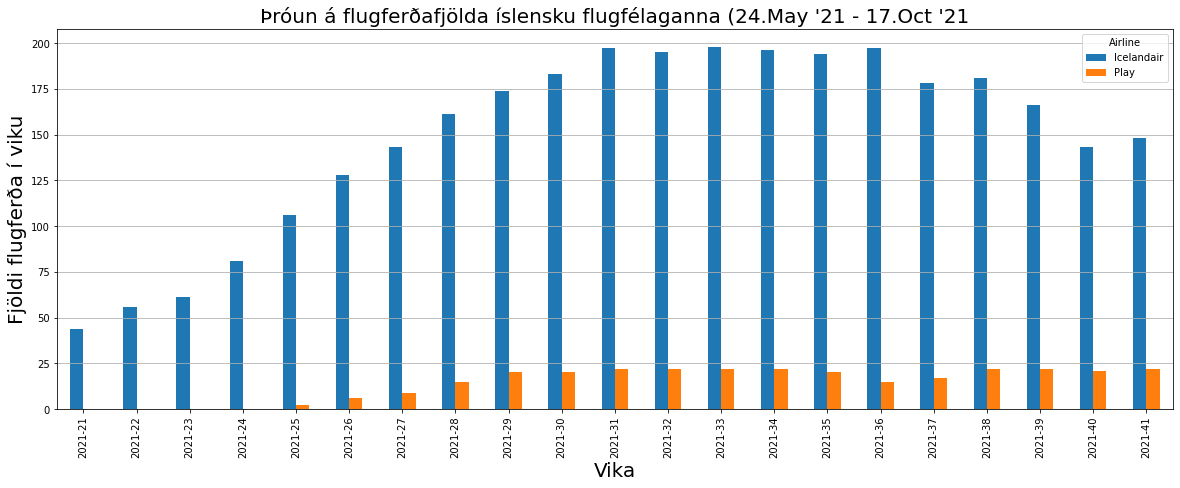

In [12]:
ax = df_result_week_count.unstack(level=1).plot.bar(figsize=(20, 7))
ax.set_title(f'Þróun á flugferðafjölda íslensku flugfélaganna ({date_range}', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika" ,fontsize=20)
ax.set_ylabel("Fjöldi flugferða í viku" ,fontsize=20)

(0.0, 105.0)

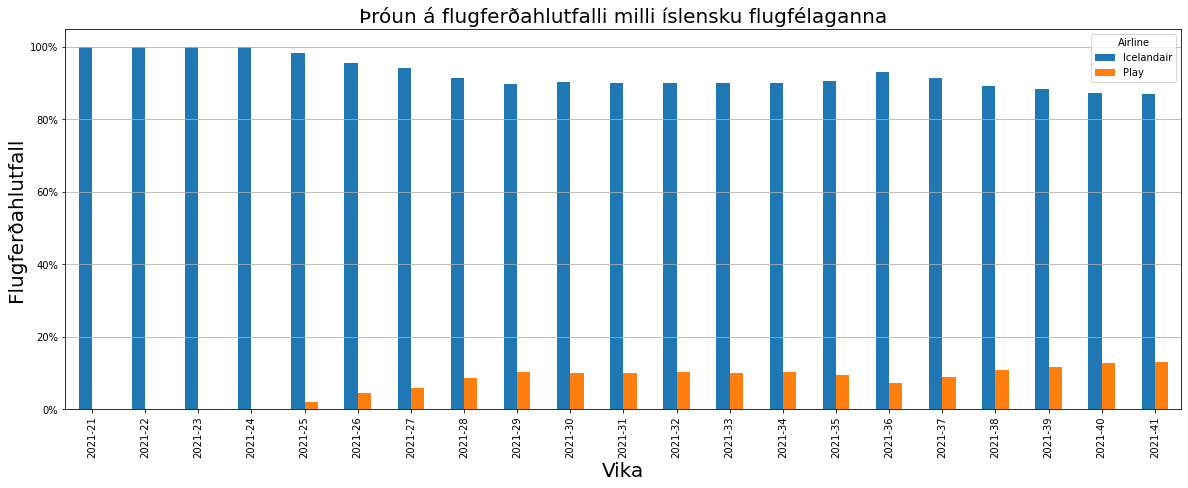

In [13]:
# figure(figsize=(2000, 6), dpi=80)
ax = df_result_week_cRatio.unstack(level=1).plot.bar(figsize=(20, 7))
ax.set_title(f'Þróun á flugferðahlutfalli milli íslensku flugfélaganna', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika" ,fontsize=20)
ax.set_ylabel("Flugferðahlutfall" ,fontsize=20)
ax.set_ylim(0, 105)

Text(0, 0.5, 'Mínútur')

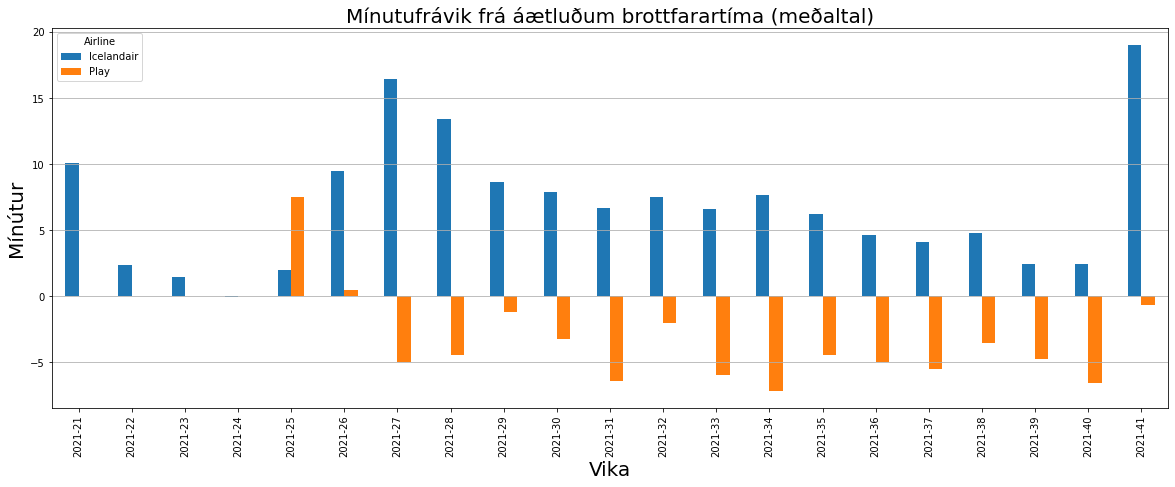

In [14]:
ax = df_result_week_mean.unstack(level=1).plot.bar(figsize=(20,7))
ax.set_title(f'Mínutufrávik frá áætluðum brottfarartíma (meðaltal)', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika" ,fontsize=20)
ax.set_ylabel("Mínútur" ,fontsize=20)

Text(0, 0.5, 'Mínútur')

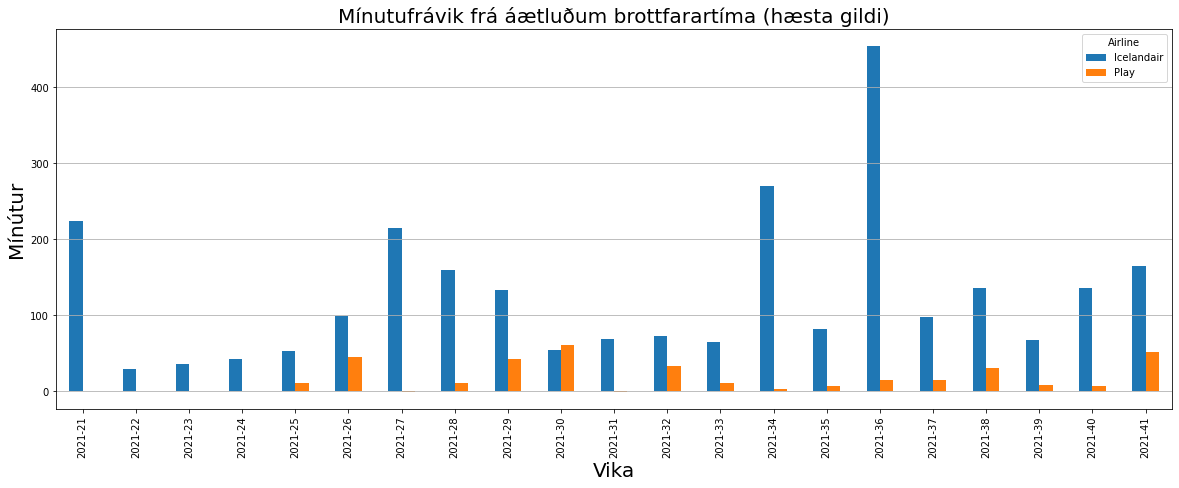

In [15]:
ax = df_result_week_max.unstack(level=1).plot.bar(figsize=(20,7))
ax.set_title(f'Mínutufrávik frá áætluðum brottfarartíma (hæsta gildi)', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika" ,fontsize=20)
ax.set_ylabel("Mínútur" ,fontsize=20)

Text(0, 0.5, 'Mínútur')

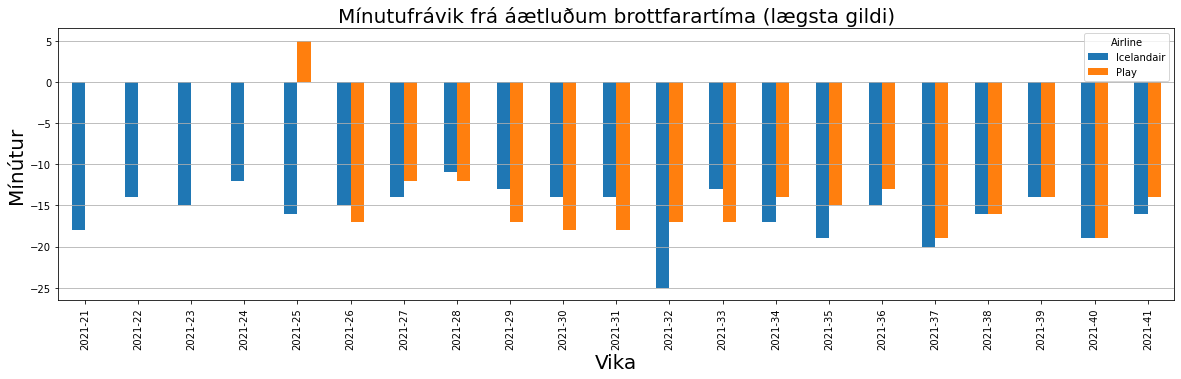

In [16]:
ax = df_result_week_min.unstack(level=1).plot.bar(figsize=(20,5))
ax.set_title(f'Mínutufrávik frá áætluðum brottfarartíma (lægsta gildi)', fontsize=20)  # or size, alternatively
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vika", fontsize=20)
ax.set_ylabel("Mínútur", fontsize=20)

Text(0, 0.5, 'Mínútur')

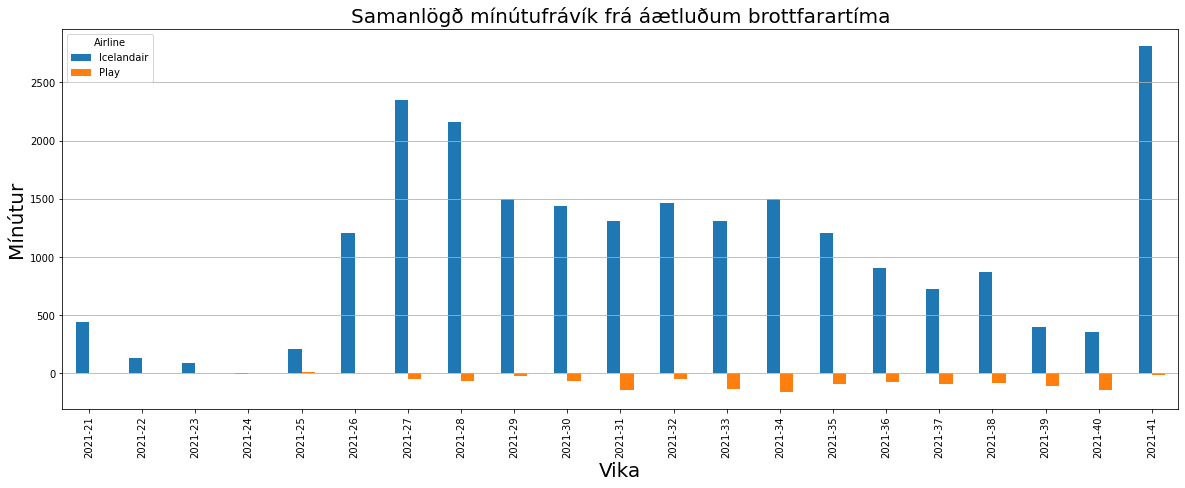

In [17]:
ax = df_result_week_sum.unstack(level=1).plot.bar(figsize=(20,7))
ax.set_title(f'Samanlögð mínútufrávík frá áætluðum brottfarartíma', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Vika", fontsize=20)
ax.set_ylabel("Mínútur", fontsize=20)

### Punctuality for Airline by Weeks:

Text(0, 0.5, 'Mínútur')

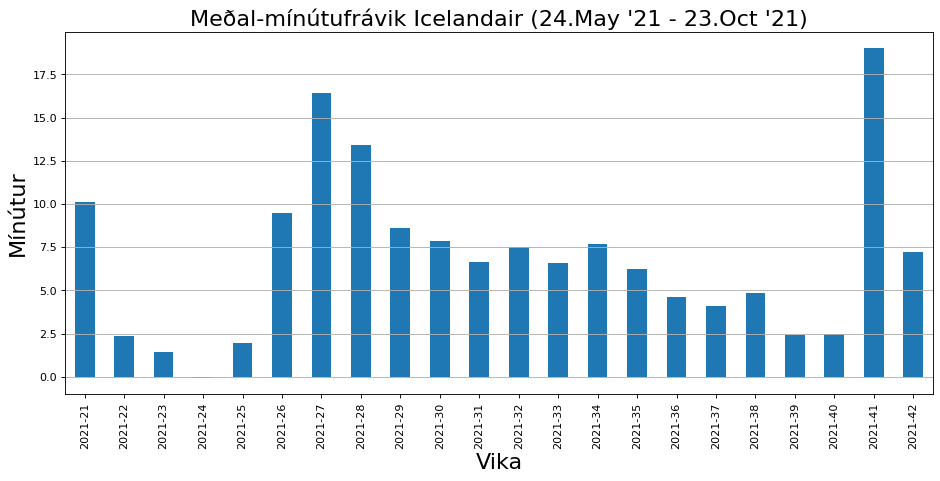

In [18]:
airline = 'Icelandair'

df_airline = df_a[df_a.Airline == airline]
df_airline = df_airline.assign(Week = df_airline.Date.dt.strftime('%Y-%W'))
date_range = GetDateRangeStr(df_airline.Date)

result_airline_destination = df_airline.groupby('Week')['pMins'].mean()


figure(figsize=(14, 6), dpi=80)
ax = result_airline_destination.plot.bar(x = 'Vika', y='Mínútufrávik')
ax.set_title(f'Meðal-mínútufrávik {airline} ({date_range})', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Vika" ,fontsize=20)
ax.set_ylabel("Mínútur" ,fontsize=20)

### Punctuality for Airline in certain Week:

In [92]:
# Parameters:
# pMin_limit is measured in minutes. Includes flights that are X minutes late.
airline = 'Icelandair'
week = current_week - 1
pMin_limit = 0

df_w = df_a[(df_a.Date.dt.week == week) & (df_a.Airline == airline)]

week_airline = df_w.loc[idx[:, ['WeekDay', 'FlightNumber', 'Destination', 'pMins']]]
week_airline = week_airline.set_index(['WeekDay', 'FlightNumber']).sort_index(level=0)

date_range = GetDateRangeStr(df_w.Date)

result = week_airline.groupby(['WeekDay', 'FlightNumber', 'Destination'])['pMins'].mean().dropna()
result_destination = result.groupby(level=2).apply(lambda x: 100 * x[x<=pMin_limit].count()/float(x.count()) )
result_weekday = result.groupby(level=0).apply(lambda x: 100 * x[x<=pMin_limit].count()/float(x.count()) )

result_destination = result_destination[result_destination > 0]
result_weekday = result_weekday[result_weekday > 0]

(0.0, 105.0)

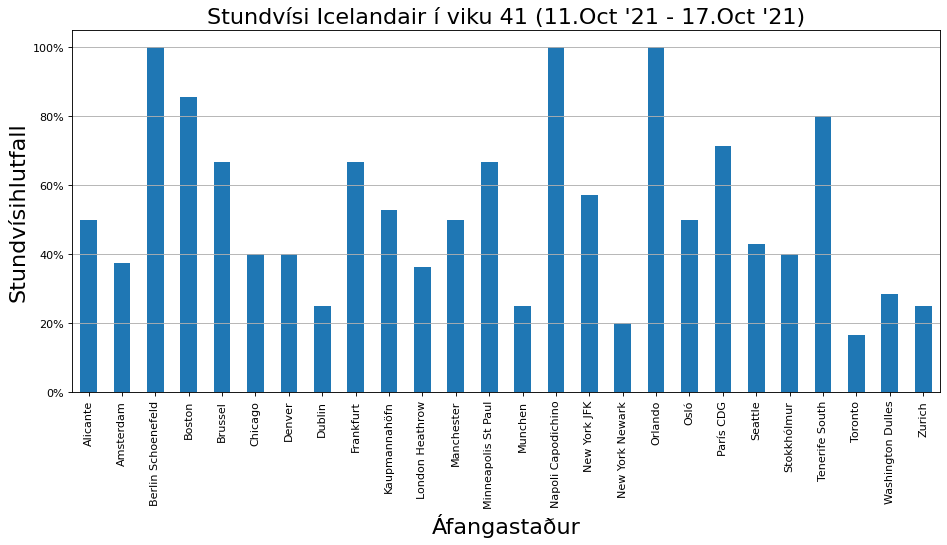

In [93]:
figure(figsize=(14, 6), dpi=80)
ax = result_destination.plot.bar()
ax.set_title(f'Stundvísi {airline} í viku {week} ({date_range})', fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Áfangastaður", fontsize=20)
ax.set_ylabel("Stundvísihlutfall", fontsize=20)
ax.set_ylim(0, 105)

Text(0, 0.5, 'Stundvísihlutfall')

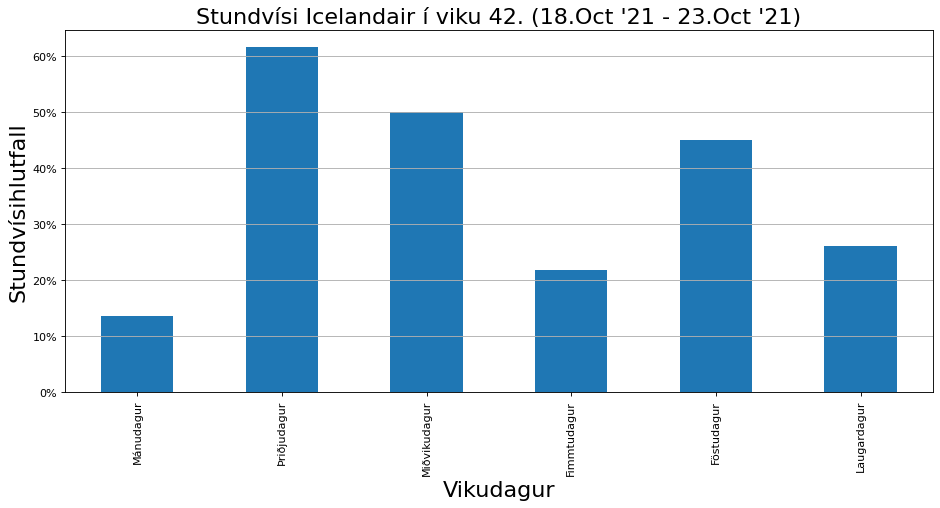

In [37]:
figure(figsize=(14, 6), dpi=80)
ax = result_weekday.plot.bar(x = 'Vikudagur', y ='Stundvísihlutfall')
ax.set_title(f'Stundvísi {airline} í viku {week}. ({date_range})', fontsize=20)  # or size, alternatively
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='y')
ax.set_xlabel("Vikudagur", fontsize=20)
ax.set_ylabel("Stundvísihlutfall", fontsize=20)

### Punctuality for Airline by Destination:

Text(0, 0.5, 'Mínútufrávik (meðaltal)')

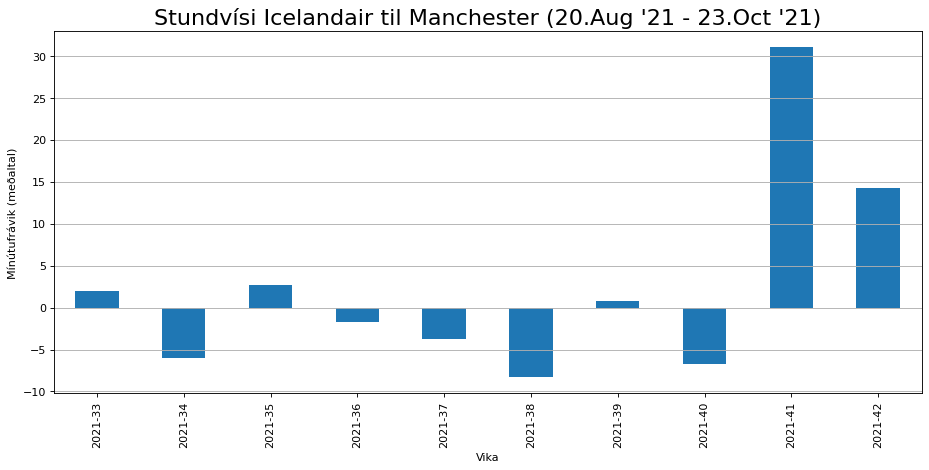

In [39]:
airline = 'Icelandair'
df_airline = df_a[df_a.Airline == airline]
destination = 'Manchester'
airline_destination = df_airline[df_airline.Destination.str.contains(destination)]
airline_destination = airline_destination.assign(Week = airline_destination.Date.dt.strftime('%Y-%W'))
date_range = GetDateRangeStr(airline_destination.Date)

result_airline_destination = airline_destination.groupby('Week')['pMins'].mean()


figure(figsize=(14, 6), dpi=80)
ax = result_airline_destination.plot.bar(x = 'Vika', y='Mínútufrávik')
ax.set_title(f'Stundvísi {airline} til {destination} ({date_range})', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Vika")
ax.set_ylabel("Mínútufrávik (meðaltal)")

### Number of Flights per Airline:

Text(0, 0.5, 'Brottfarir')

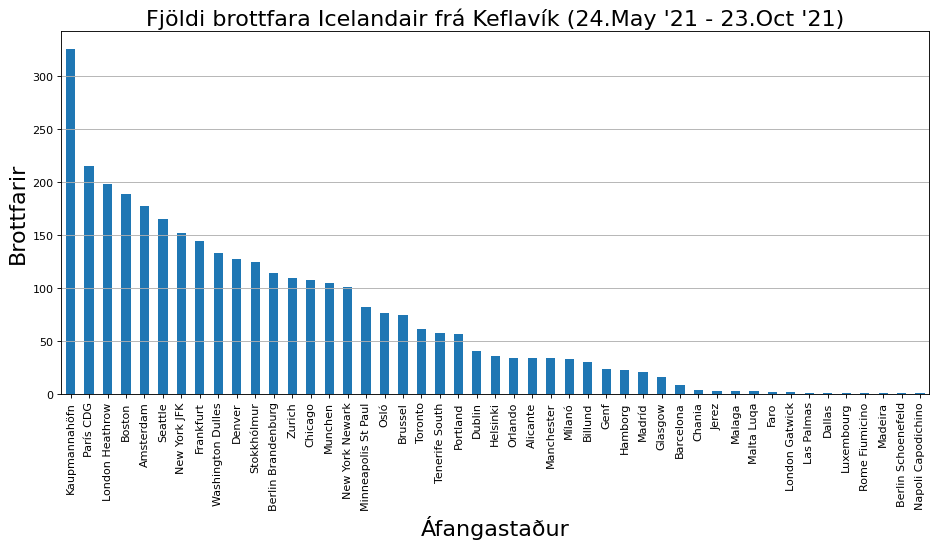

In [41]:
airline = 'Icelandair'
df_airline = df_a[df_a.Airline == airline]
# df_airline = df_airline.assign(Week = df_airline.Date.dt.strftime('%Y-%W'))
date_range = GetDateRangeStr(df_airline.Date)

result_airline_destination_count = df_airline.groupby('Destination')['pMins'].count().sort_values(ascending=False)

figure(figsize=(14, 6), dpi=80)
# result_airline_destination
ax = result_airline_destination_count.plot.bar()
ax.set_title(f'Fjöldi brottfara {airline} frá Keflavík ({date_range})', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Áfangastaður" ,fontsize=20)
ax.set_ylabel("Brottfarir" ,fontsize=20)

Text(0, 0.5, 'Brottfarir')

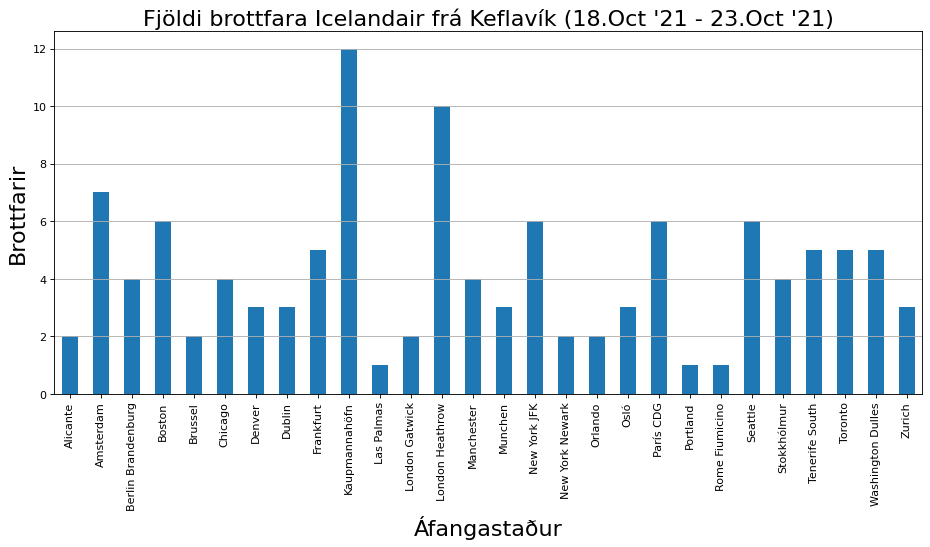

In [42]:
airline = 'Icelandair'
week = current_week

df_airline = df_a[(df_a.Airline == airline) & (df_a.Date.dt.week == week)]
# df_airline = df_airline.assign(Week = df_airline.Date.dt.strftime('%Y-%W'))
date_range = GetDateRangeStr(df_airline.Date)

result_airline_destination_count = df_airline.groupby('Destination')['pMins'].count()

figure(figsize=(14, 6), dpi=80)
# result_airline_destination
ax = result_airline_destination_count.plot.bar()
ax.set_title(f'Fjöldi brottfara {airline} frá Keflavík ({date_range})', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Áfangastaður" ,fontsize=20)
ax.set_ylabel("Brottfarir" ,fontsize=20)

Text(0, 0.5, 'Mínútur')

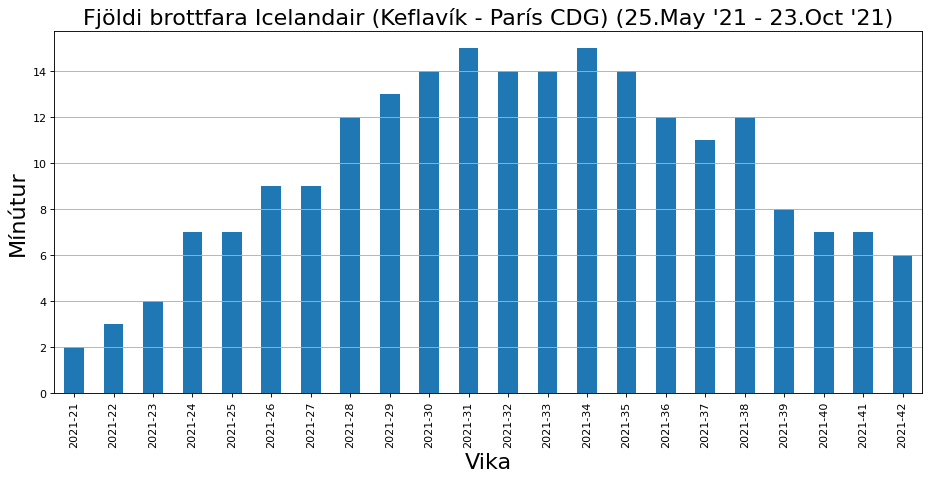

In [68]:
airline = 'Icelandair'
destination = 'París CDG'

df_airline = df_a[(df_a.Airline == airline) & (df_a.Destination == destination)]
df_airline = df_airline.assign(Week = df_airline.Date.dt.strftime('%Y-%W'))
date_range = GetDateRangeStr(df_airline.Date)

result_airline_destination = df_airline.groupby('Week')['pMins'].count()

figure(figsize=(14, 6), dpi=80)
ax = result_airline_destination.plot.bar(x = 'Vika', y='Mínútufrávik')
ax.set_title(f'Fjöldi brottfara {airline} (Keflavík - {destination}) ({date_range})', fontsize=20)  # or size, alternatively
ax.grid(axis='y')
ax.set_xlabel("Vika" ,fontsize=20)
ax.set_ylabel("Mínútur" ,fontsize=20)